In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from IPython.display import FileLink

In [3]:
def gen_splits(n, df, label_col):
    skf = StratifiedKFold(n_splits=n, random_state=42, shuffle=True)
    splits = skf.get_n_splits(range(len(df)))
    indexes = range(len(df))
    return skf.split(indexes, df[label_col])

In [4]:
model_type='full-60k'
# model_type='full-30k'
# model_type='samlple-30k'

In [7]:
path=Path('data')

In [15]:
# df_train = pd.read_csv(path/'nlp_train_sample.csv', low_memory=False).fillna('')
df_train = pd.read_csv(path/'nlp_train.csv', low_memory=False).fillna('')

In [16]:
split = [s for s in gen_splits(10, df_train, 'root_cause')][3]

In [6]:
##### Packaging for models

In [5]:
bs=64

In [9]:
# data_lm = load_data(path, f'data-lm-{model_type}.pkl', bs=bs)

In [9]:
# data_clas = (TextList.from_df(df_train, path, vocab=data_lm.vocab)
#              .split_by_idxs(split[0], split[1])
#              .label_from_df('root_cause')
#              .databunch(bs=bs))
# data_clas.save(f'data_clas_{model_type}.pkl')

In [8]:
bs = 128 # 192 breaks in unfreeze(); 256 breaks in freeze(-3)
data_clas = load_data(path, f'data_clas_{model_type}.pkl', bs=bs)

### Classifier

In [9]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{model_type}-tuned-enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


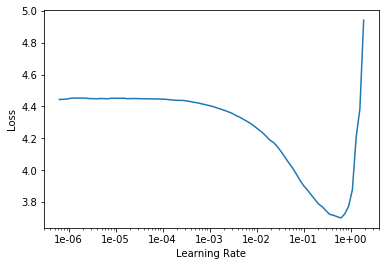

In [33]:
learn.lr_find(); learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8, 0.7)); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,2.060810,1.918456,0.431876,15:37
1,1.968518,1.858050,0.441696,15:08


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
learn.save(f'nlp-classifier-{model_type}-1')

In [38]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


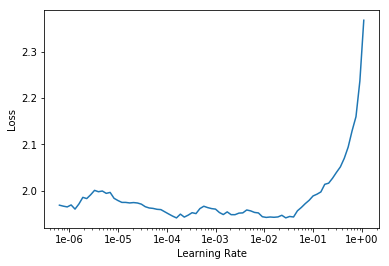

In [39]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.874181,1.778999,0.459916,17:05
1,1.843690,1.742046,0.467711,18:44
2,1.854966,1.738470,0.469398,17:41


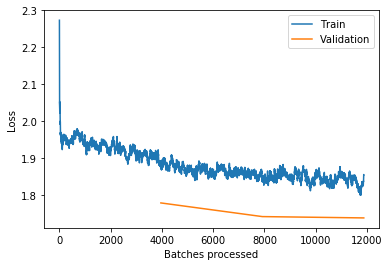

In [41]:
learn.fit_one_cycle(3, slice(5e-4/(2.6**4),5e-4), moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [42]:
learn.save(f'nlp-classifier-{model_type}-2')

In [14]:
learn.load(f'nlp-classifier-{model_type}-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1013480 items)
x: TextList
xxbos opstechit - xxup hou2 xxmaj project opstechit xxmaj manual opstechit xximpacthigh xxmaj equipment xxmaj request ( xxmaj new / xxmaj loaner ) xxup hou2 - xxup fc ( xxmaj houston , xxup tx ) xxmaj sort - xxup ar xxup houston xxup us xxup hou2 xxup tx xxmaj client xxmaj devices xxup hou2 - xxmaj singles problem solve request xxmaj building i d : xxup hou2 xxmaj workflow name : opstechit_devices_and_equipment_other xxmaj description : xxmaj problem xxmaj solve xxmaj stations on xxmaj line 3 , 4 , & 5 as well as xxmaj audit at xxmaj slam 6 in xxmaj pack xxmaj singles need to be fully setup as problem solve & xxmaj pack xxmaj stations . xxmaj each location must be fully functional for problem solve to pack out items . xxmaj in addition to work tables , equipment needed : xxmaj tape xxmaj dispensers , xxmaj dunnage xxmaj machines , xxmaj full xxmaj box xxmaj suites , xxmaj spoo xxmaj machines , p - xxmaj sl

In [15]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


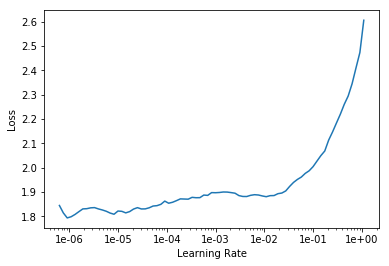

In [16]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.821350,1.724183,0.472497,28:54
1,1.811098,1.711723,0.475738,28:38
2,1.831211,1.707143,0.476688,29:45


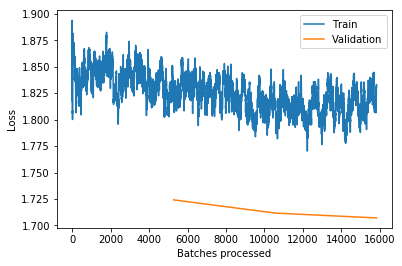

In [17]:
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [19]:
learn.save(f'nlp-classifier-{model_type}-3')

In [10]:
learn.load(f'nlp-classifier-{model_type}-3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1013480 items)
x: TextList
xxbos opstechit - xxup hou2 xxmaj project opstechit xxmaj manual opstechit xximpacthigh xxmaj equipment xxmaj request ( xxmaj new / xxmaj loaner ) xxup hou2 - xxup fc ( xxmaj houston , xxup tx ) xxmaj sort - xxup ar xxup houston xxup us xxup hou2 xxup tx xxmaj client xxmaj devices xxup hou2 - xxmaj singles problem solve request xxmaj building i d : xxup hou2 xxmaj workflow name : opstechit_devices_and_equipment_other xxmaj description : xxmaj problem xxmaj solve xxmaj stations on xxmaj line 3 , 4 , & 5 as well as xxmaj audit at xxmaj slam 6 in xxmaj pack xxmaj singles need to be fully setup as problem solve & xxmaj pack xxmaj stations . xxmaj each location must be fully functional for problem solve to pack out items . xxmaj in addition to work tables , equipment needed : xxmaj tape xxmaj dispensers , xxmaj dunnage xxmaj machines , xxmaj full xxmaj box xxmaj suites , xxmaj spoo xxmaj machines , p - xxmaj sl

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


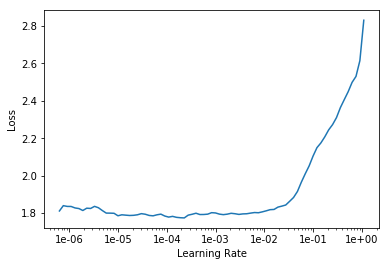

In [12]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.800186,1.702261,0.477691,42:57
1,1.792302,1.697239,0.478713,43:31


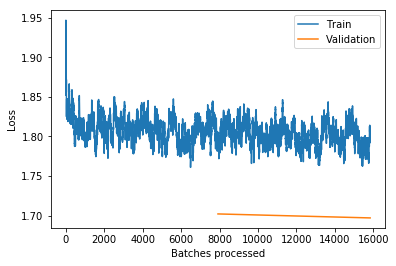

In [13]:
learn.fit_one_cycle(2, slice(5e-5/(2.6**4),5e-5), moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [14]:
learn.save(f'nlp-classifier-{model_type}-final')

In [15]:
learn.export(f'nlp-classifier-{model_type}-final-export.pkl')

* sample-30k: pub score: 0.42716158016
* large-60k: 0.469047052033

# Quality

### Large-60k

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

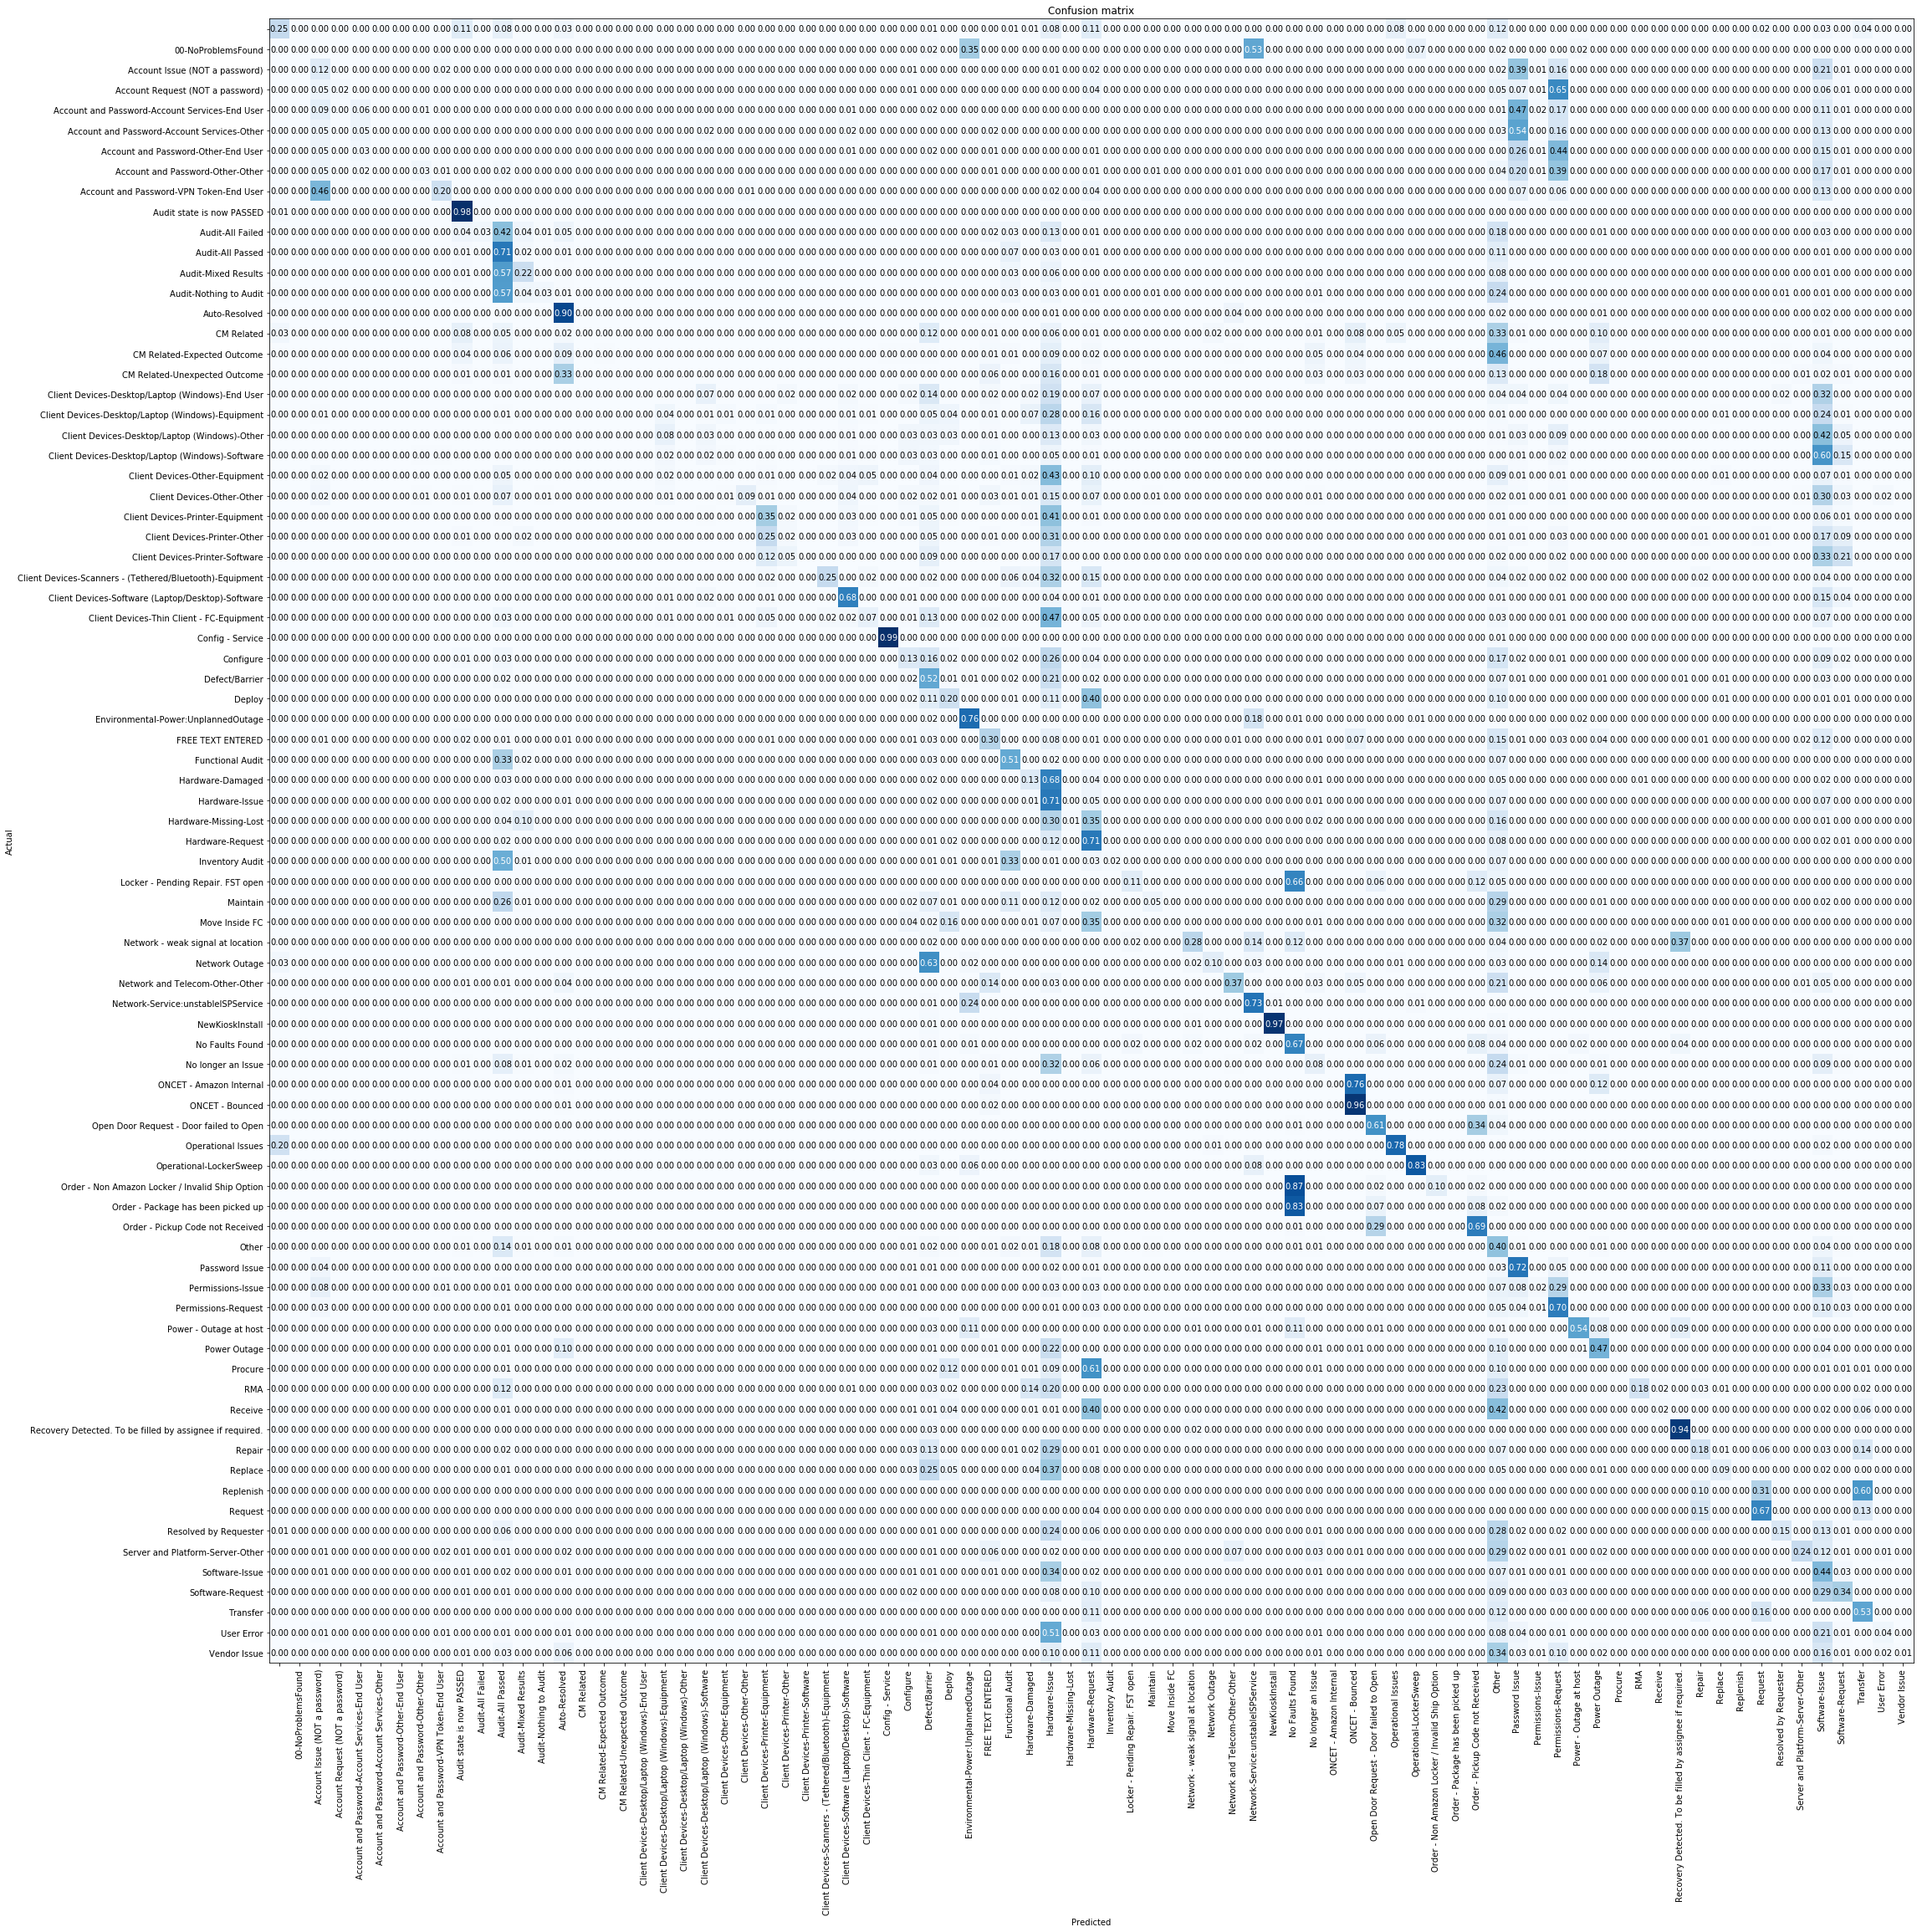

In [17]:
interp.plot_confusion_matrix(figsize=(32,32), normalize=True)

### Sample-30k

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

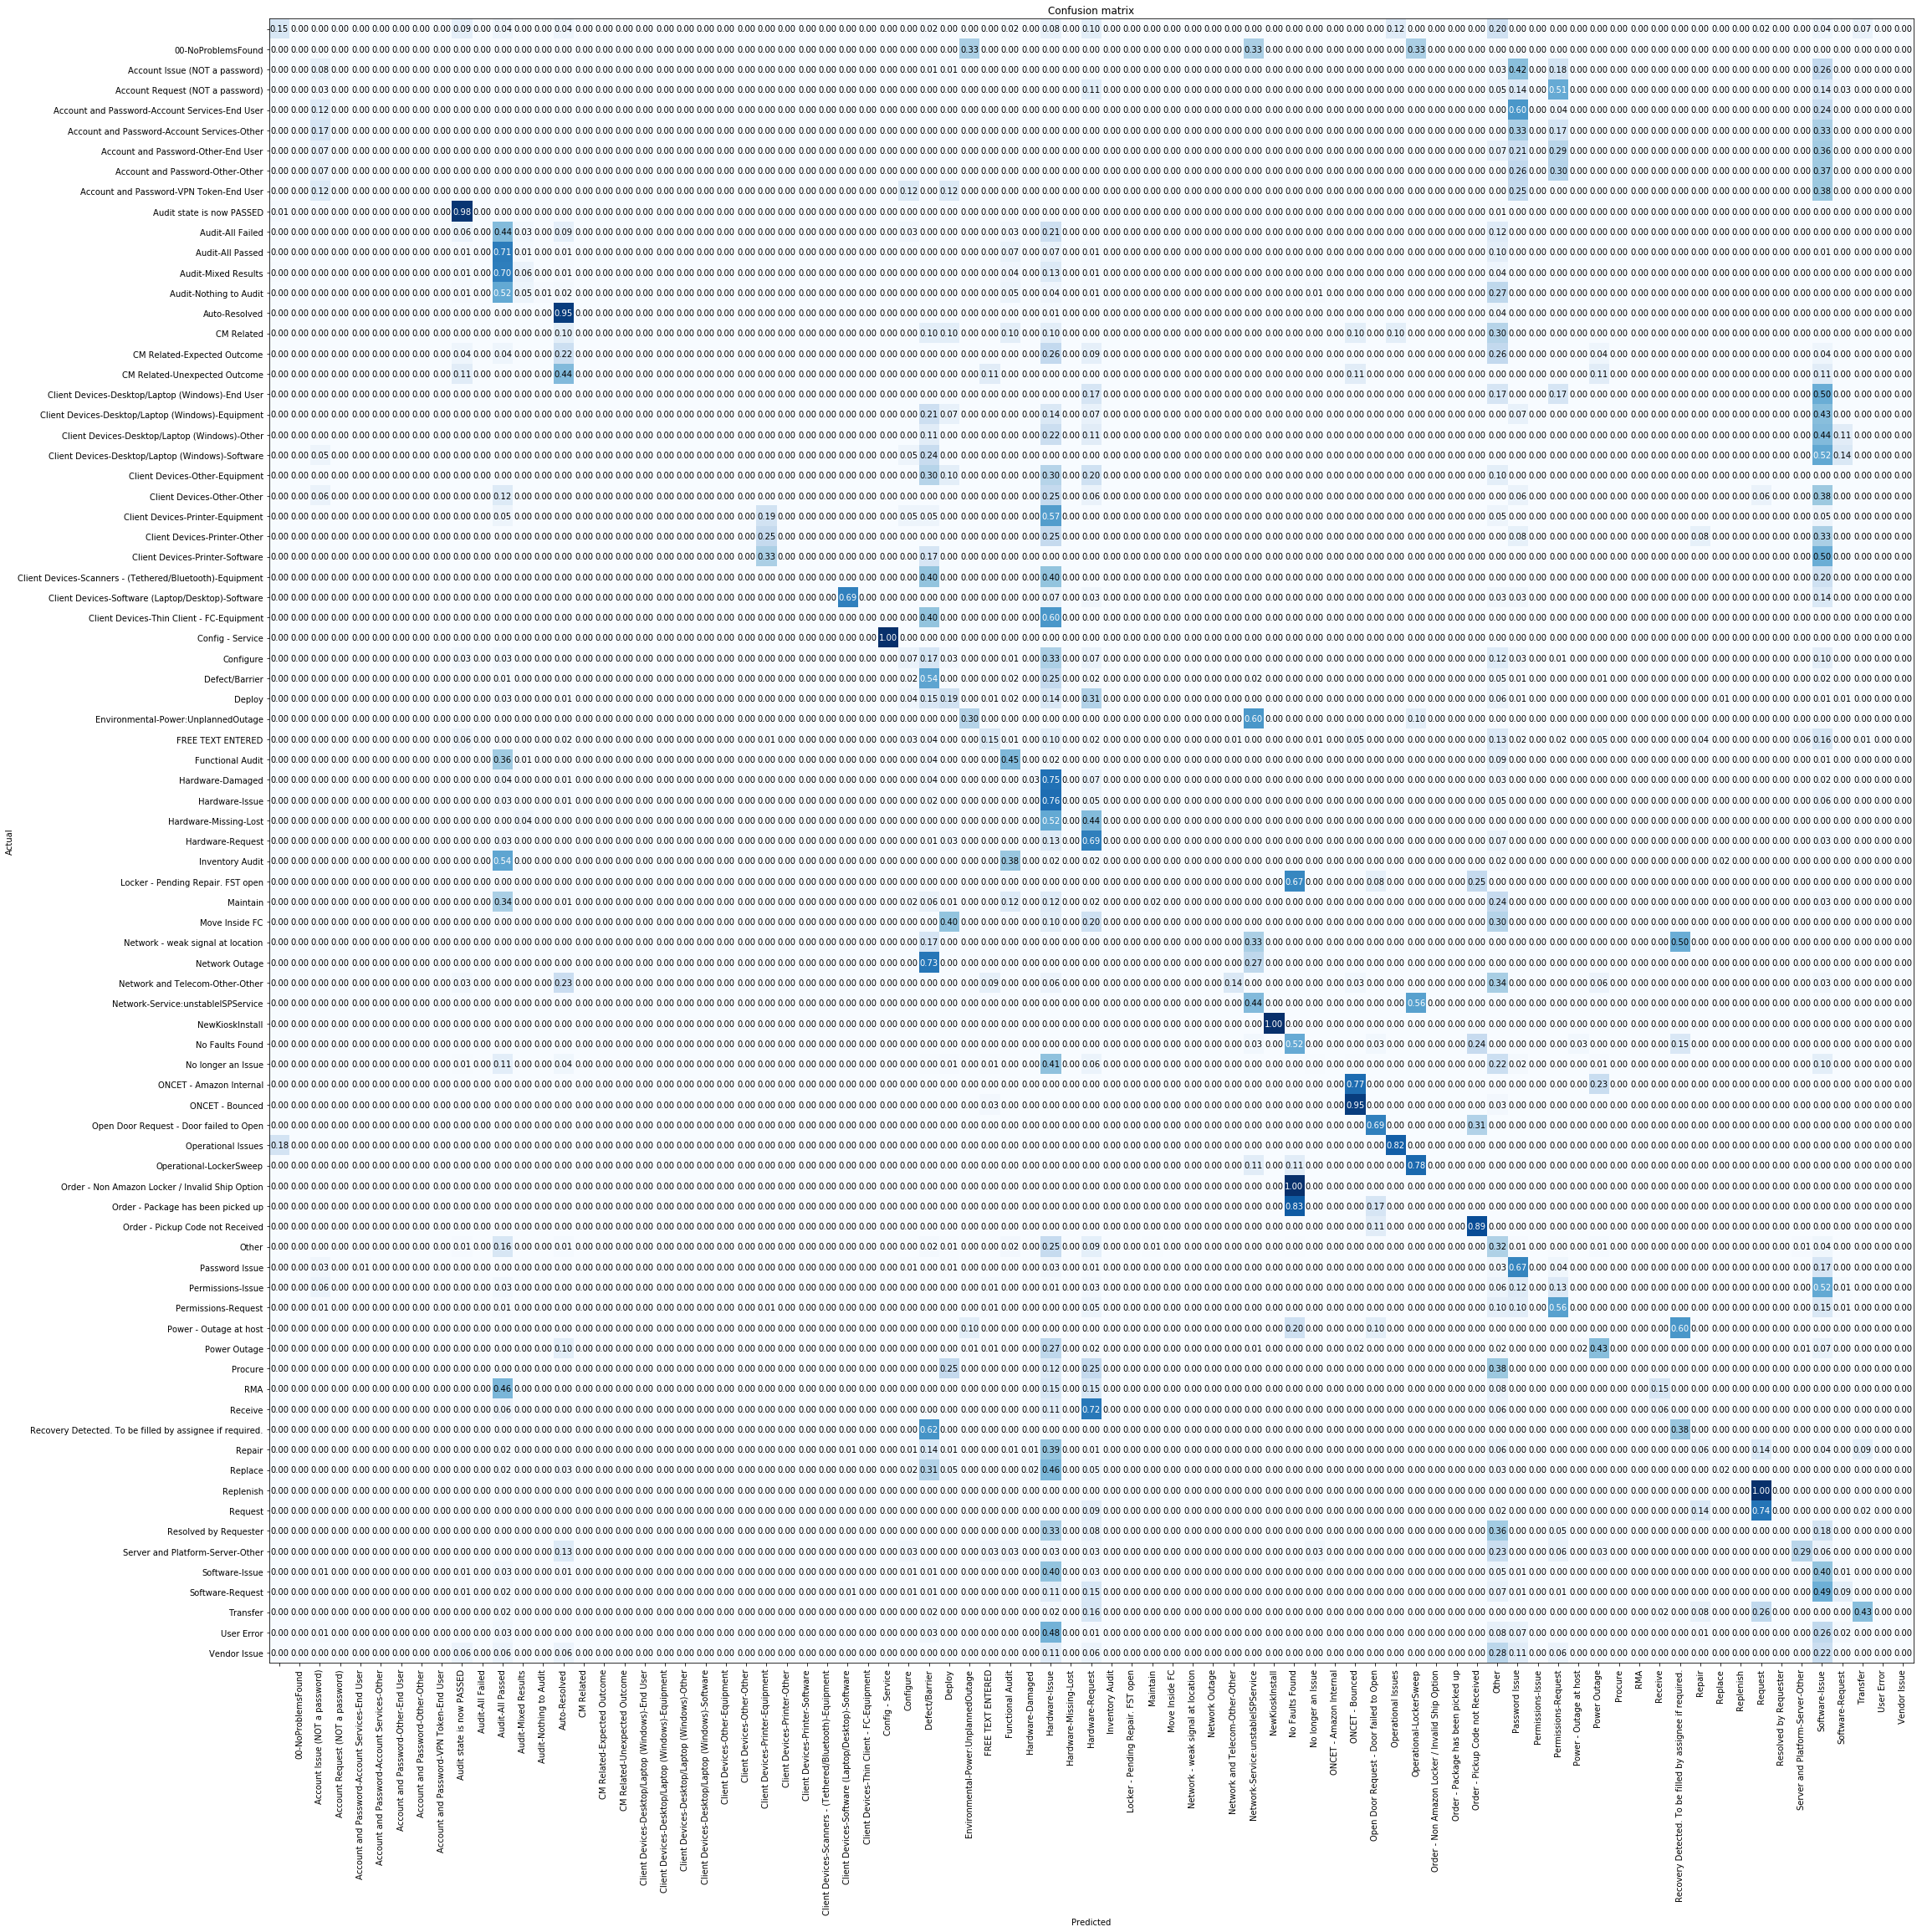

In [53]:
interp.plot_confusion_matrix(figsize=(32,32), normalize=True)

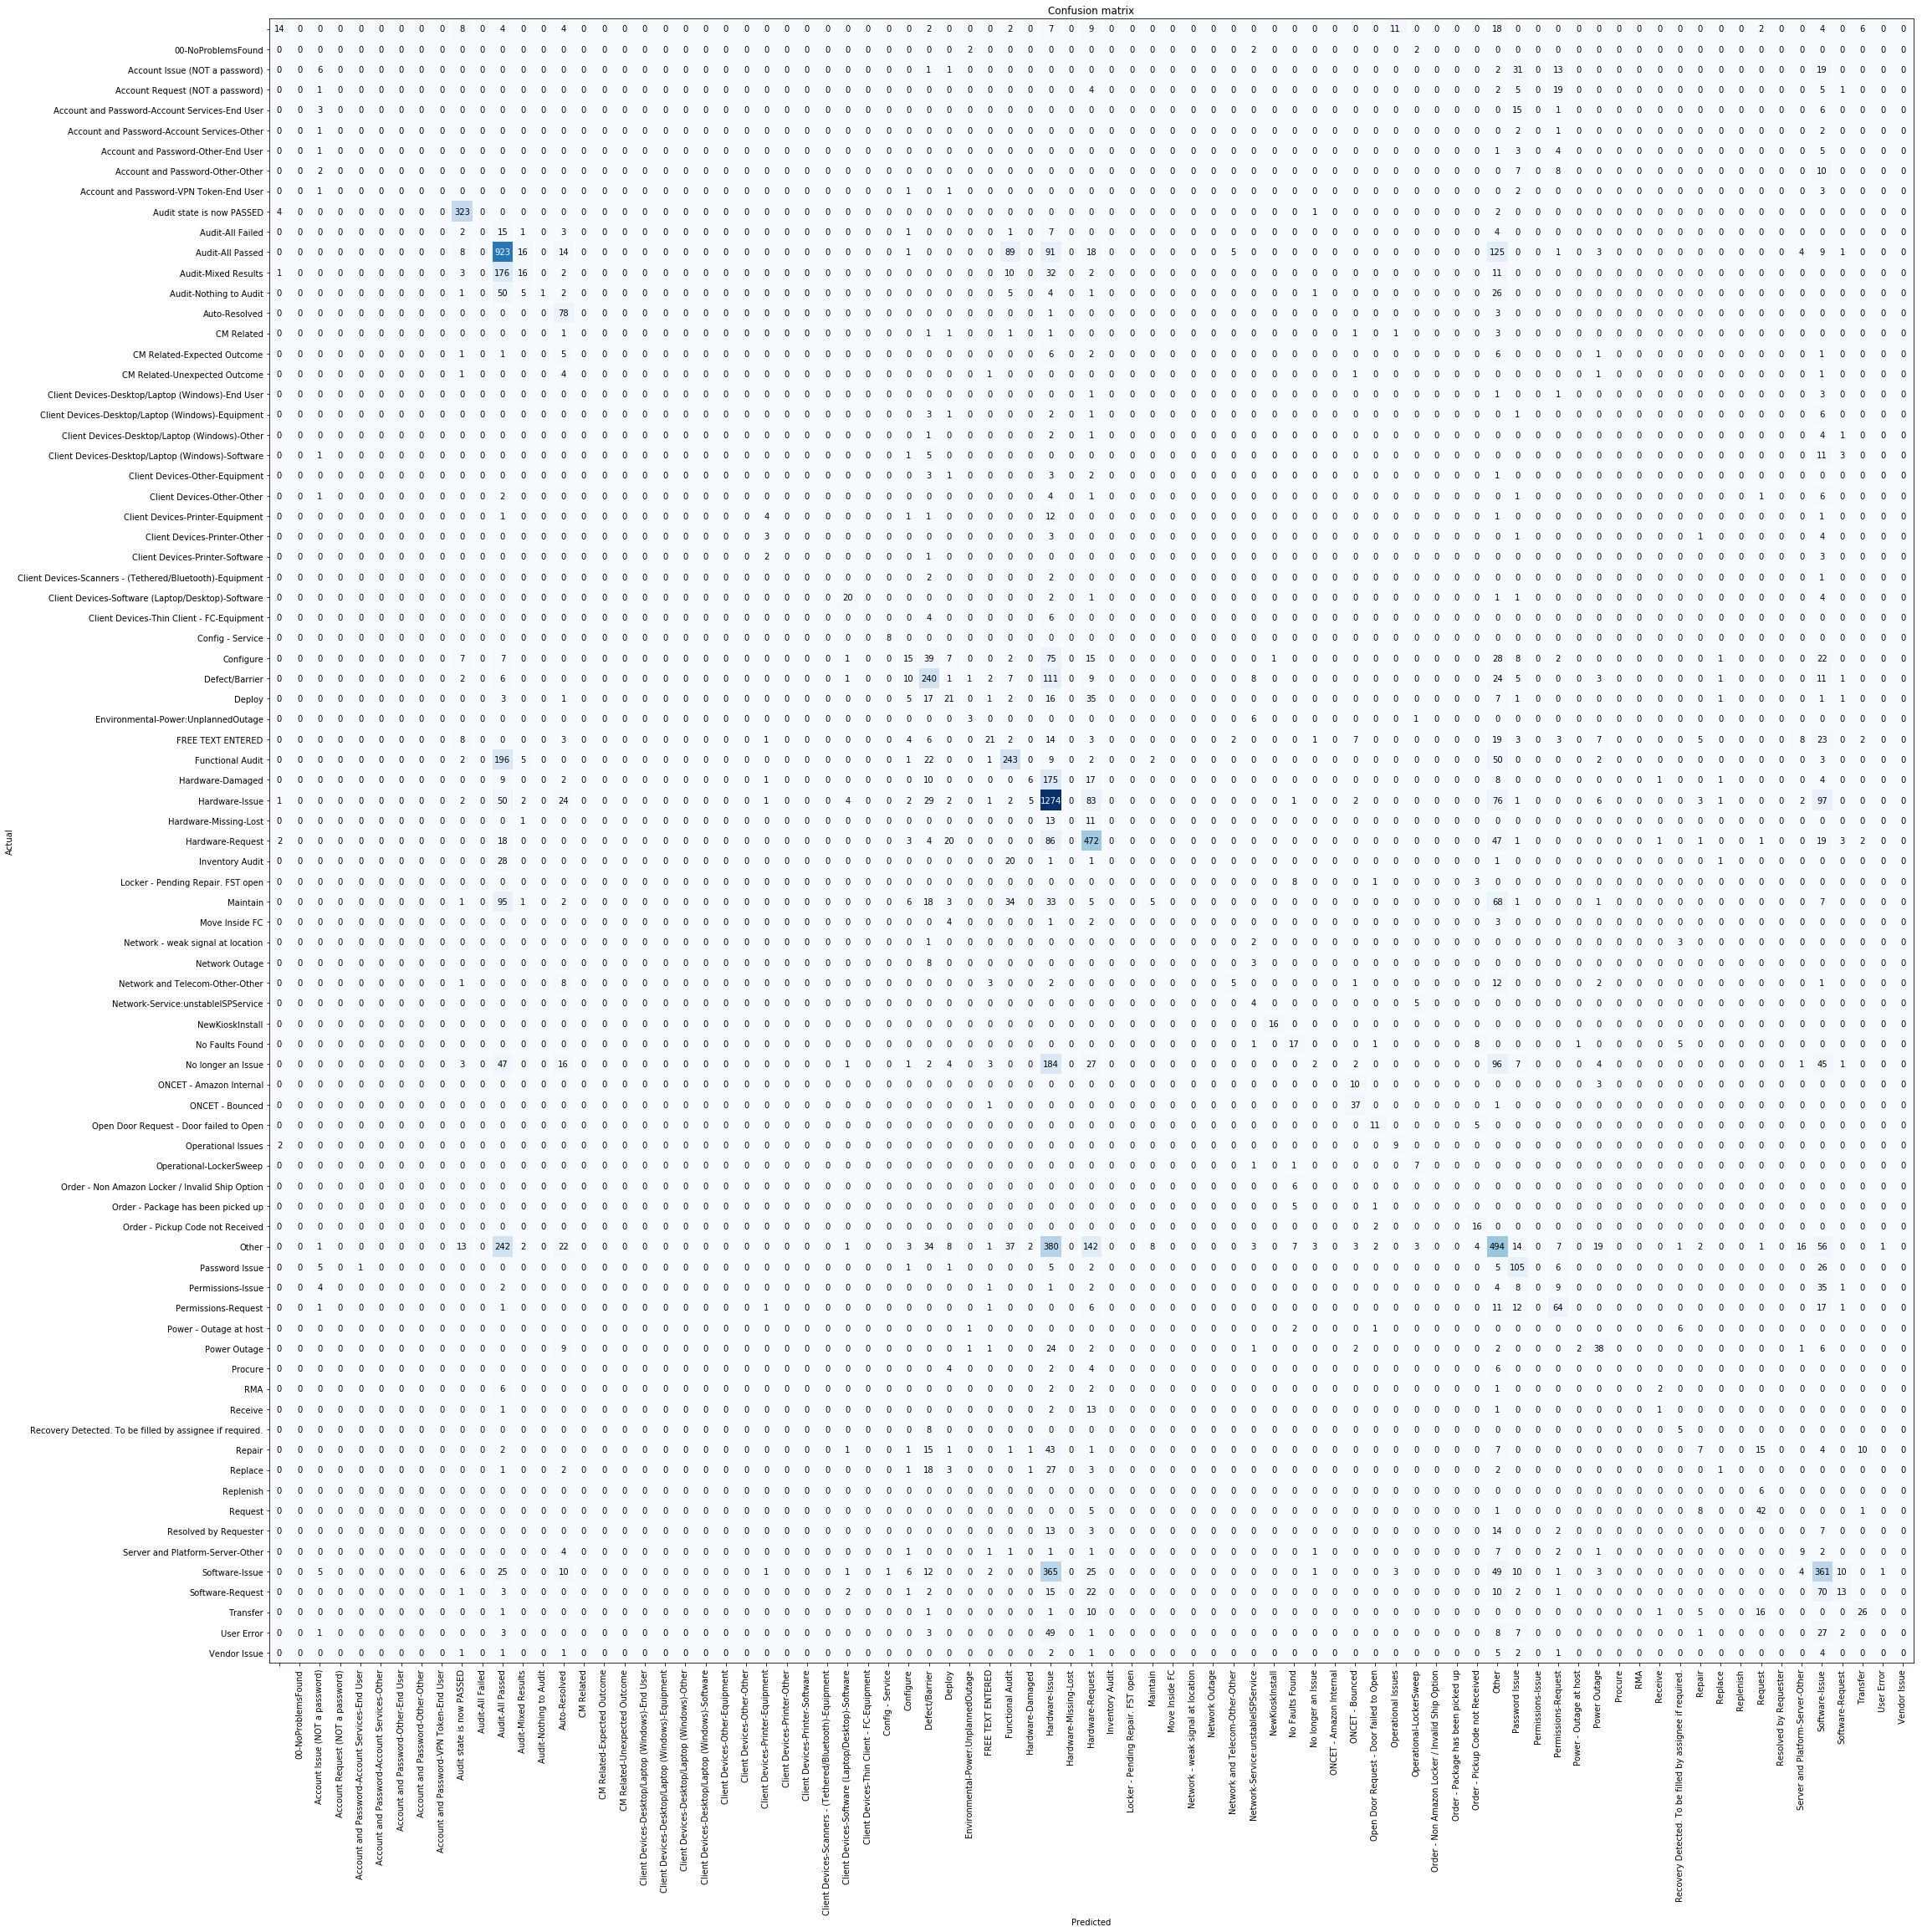

In [55]:
interp.plot_confusion_matrix(figsize=(32,32))